In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMPORTS
import pandas as pd
import os
import yfinance as yf
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report

In [ ]:
# 1. aggregating all the cleaned data
text_directory_path = '/content/drive/My Drive/CSCI-499 Project/new_text/'

In [ ]:
def aggregate_text(file_path):
  file_name = file_path.split('/')[-1]
  date_str = file_name.split('fdata')[1].split('_')[0]
  date = pd.to_datetime(date_str, format='%Y-%m-%d')

  try:
    df = pd.read_csv(file_path)
    text = ' '.join(df['text'].astype(str))
    return {'Date': date, 'ConcatenatedText': text}

  except:
    return {'Date': date, 'ConcatenatedText': None}

In [ ]:
count = 0
aggregated_data = []
print('Total files in new_text directory - ', len(os.listdir(text_directory_path)))
for file_name in os.listdir(text_directory_path):
  # if count > 100:
  #   break
  aggregated_data.append(aggregate_text(os.path.join(text_directory_path, file_name)))
  count += 1

combined_df = pd.DataFrame(aggregated_data, columns=['Date', 'ConcatenatedText'])
combined_df.sort_values(by='Date', inplace=True)
combined_df.reset_index(drop=True, inplace=True)
print(count)

Total files in new_text directory -  642
642


In [ ]:
# Merging VIX data
vix_ticker = "^VIX"
vix = yf.Ticker(vix_ticker)
vix_data = vix.history(start="2019-01-01", end="2022-12-31")
vix_data.reset_index(inplace=True)
vix_data['Date'] = pd.to_datetime(vix_data['Date'], format='%Y-%m-%d').dt.tz_localize(None)
combined_df = pd.merge(combined_df, vix_data[['Date', 'Close']], on='Date', how='inner')
combined_df.rename(columns={'Close': 'VIX_Close'}, inplace=True)
combined_df

Date                                   ConcatenatedText  VIX_Close
0   2019-01-02  the rockies have signed outfielder michael sau...  23.219999
1   2019-01-03  veracyte to present at the 37th annual j p mor...  25.450001
2   2019-01-04  the rare warning of disappointing results from...  21.379999
3   2019-01-07  loading loading gilead sciences inc gild and y...  21.400000
4   2019-01-08  a rise in the industrials and health care sect...  20.469999
..         ...                                                ...        ...
439 2022-12-23  as children around the globe gear up for chris...  20.870001
440 2022-12-27  both dr mayank amin and his wife are pharmacis...  21.650000
441 2022-12-28  billionaires have had a bad year globally the ...  22.139999
442 2022-12-29  ein news lafox ill dec 28 2022 globe newswire ...  21.440001
443 2022-12-30  above until ice sets up universally smaller wa...  21.670000

[444 rows x 3 columns]

In [ ]:
combined_df['ConcatenatedText'].fillna('', inplace=True)

In [ ]:
combined_df.to_csv("/content/drive/My Drive/CSCI-499 Project/combined_df.csv", index=False)

In [ ]:
combined_df = pd.read_csv('/content/drive/My Drive/CSCI-499 Project/combined_df.csv')

In [ ]:
combined_df['ConcatenatedText'].fillna('', inplace=True)

In [ ]:
combined_df['ConcatenatedText'] = combined_df['ConcatenatedText'].astype(str)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
articles = combined_df['ConcatenatedText'].tolist()

In [ ]:
for c in articles:
  if not isinstance(c, str):
    c = ''
    print('hello', type(c), c)

In [ ]:
for c in articles:
  if not isinstance(c, str):
    print('hello', type(c), c)

In [ ]:
inputs = tokenizer(articles, padding = True, truncation = True, return_tensors='pt')
print(inputs)

In [ ]:
sentiment_labels = []
sentiment_scores = []

In [ ]:
batch_size = 10  # Adjust batch size as needed
for i in range(0, len(articles), batch_size):
    batch_articles = articles[i:i + batch_size]

    # Tokenize batch of articles
    inputs = tokenizer(batch_articles, padding=True, truncation=True, return_tensors='pt', max_length=512)

    # Pass tokenized batch to the model for sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Interpret results
    probabilities = torch.softmax(logits, dim=1)
    for j, article in enumerate(batch_articles):
        sentiment_scores.append(probabilities[j].tolist())
        sentiment_labels.append(model.config.id2label[int(torch.argmax(probabilities[j]))])

# Create a DataFrame from the sentiment analysis results
df = pd.DataFrame({
    'Article': articles,
    'Sentiment Label': sentiment_labels,
    'Sentiment Scores': sentiment_scores
})

In [ ]:
df.to_csv('/content/drive/My Drive/CSCI-499 Project/finbert_sentiment.csv', index=False)

Article Sentiment Label  \
0    the rockies have signed outfielder michael sau...         neutral   
1    veracyte to present at the 37th annual j p mor...         neutral   
2    the rare warning of disappointing results from...        negative   
3    loading loading gilead sciences inc gild and y...         neutral   
4    a rise in the industrials and health care sect...        positive   
..                                                 ...             ...   
439  as children around the globe gear up for chris...         neutral   
440  both dr mayank amin and his wife are pharmacis...         neutral   
441  billionaires have had a bad year globally the ...        negative   
442  ein news lafox ill dec 28 2022 globe newswire ...         neutral   
443  above until ice sets up universally smaller wa...         neutral   

                                      Sentiment Scores  
0    [0.04490236937999725, 0.212665855884552, 0.742...  
1    [0.05169471353292465, 0.05631730705499649, 0.8...  
2    [0.009083995595574379, 0.963883638381958, 0.02...  
3    [0.4697088301181793, 0.009496340528130531, 0.5...  
4    [0.9122073650360107, 0.023470815271139145, 0.0...  
..                                                 ...  
439  [0.035990431904792786, 0.27062883973121643, 0....  
440  [0.07322915643453598, 0.09254230558872223, 0.8...  
441  [0.011535725556313992, 0.8607645034790039, 0.1...  
442  [0.10293281823396683, 0.012502986006438732, 0....  
443  [0.06937243789434433, 0.035361774265766144, 0....  

[444 rows x 3 columns]

In [ ]:
df.to_csv('/content/drive/My Drive/CSCI-499 Project/finbert_sentiment.csv', index=False)

NameError: name 'df' is not defined

In [ ]:
def find_max_in_list(lst):
    return max(lst)

# Apply the function to each row of the 'Values' column and store the result in a new column


In [ ]:
combined_df

Date                                   ConcatenatedText  VIX_Close
0    2019-01-02  the rockies have signed outfielder michael sau...  23.219999
1    2019-01-03  veracyte to present at the 37th annual j p mor...  25.450001
2    2019-01-04  the rare warning of disappointing results from...  21.379999
3    2019-01-07  loading loading gilead sciences inc gild and y...  21.400000
4    2019-01-08  a rise in the industrials and health care sect...  20.469999
..          ...                                                ...        ...
439  2022-12-23  as children around the globe gear up for chris...  20.870001
440  2022-12-27  both dr mayank amin and his wife are pharmacis...  21.650000
441  2022-12-28  billionaires have had a bad year globally the ...  22.139999
442  2022-12-29  ein news lafox ill dec 28 2022 globe newswire ...  21.440001
443  2022-12-30  above until ice sets up universally smaller wa...  21.670000

[444 rows x 3 columns]

In [ ]:
sent_df = pd.read_csv('/content/drive/My Drive/CSCI-499 Project/finbert_sentiment.csv')

In [ ]:
df = sent_df['Sentiment Label']

In [ ]:
from scipy.stats import pearsonr

In [ ]:
label_mapping = {'positive': 1, 'negative': 0, 'neutral': 0.5}
numeric_labels = [label_mapping[label] for label in sent_df['Sentiment Label']]

In [ ]:
correlation_coefficient, p_value = pearsonr(numeric_labels, combined_df['VIX_Close'])

In [ ]:
correlation_coefficient

-0.12114956010692046

In [ ]:
p_value

0.010618757560159705

In [ ]:
from scipy.stats import pointbiserialr

In [ ]:
correlation_coefficient, p_value = pointbiserialr(combined_df['VIX_Close'], numeric_labels)

print("Point-Biserial Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Point-Biserial Correlation Coefficient: -0.12114956010692046
P-value: 0.010618757560159705


Text(0, 0.5, 'Price')

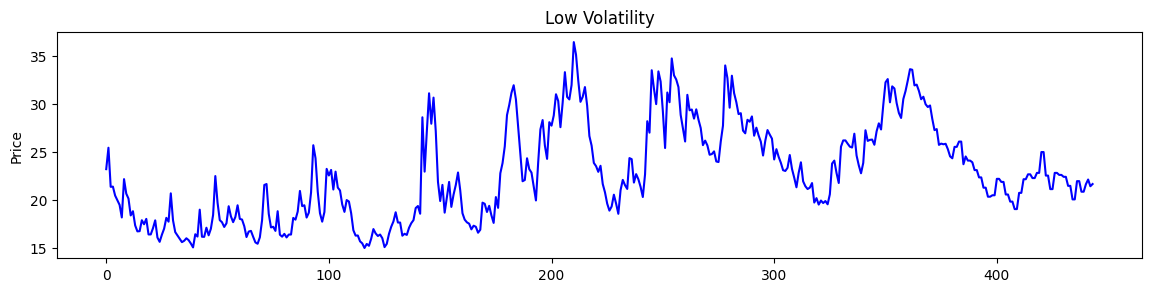

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Setting a seed for reproducibility
np.random.seed(0)

# Generate data for each scenario
# Time array (e.g., days)
volatility_index = combined_df['VIX_Close']

# Re-plotting the scenarios with adjusted volatility levels
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(volatility_index,color='blue')
plt.title('Low Volatility')
plt.ylabel('Price')

In [ ]:
volatility_index

0      23.219999
1      25.450001
2      21.379999
3      21.400000
4      20.469999
         ...    
439    20.870001
440    21.650000
441    22.139999
442    21.440001
443    21.670000
Name: VIX_Close, Length: 444, dtype: float64

In [ ]:
df = pd.DataFrame(sent_df['Sentiment Scores'])

In [ ]:
def find_max_in_list(lst):
    return max(lst)

# Apply the function to each row of the 'Sentiment Scores' column and store the result in a new column
df['Max_Sentiment'] = df['Sentiment Scores'].apply(find_max_in_list)

In [ ]:
with torch.no_grad():
    output = model(**inputs)
    # Output logits for each sentiment class
    logits = output.logits

In [ ]:
outputs = model(inputs)
print(outputs.logits.shape)

In [ ]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

In [ ]:
model.config.id2label

In [ ]:
!pip3 install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

def calculate_compound_score(sentiment_scores):
    # Initialize the sentiment analysis pipeline
    sentiment_pipeline = pipeline("sentiment-analysis")

    # Convert the list of sentiment scores to a single string
    sentiment_text = ' '.join(map(str, sentiment_scores))

    # Perform sentiment analysis and extract the compound score
    result = sentiment_pipeline(sentiment_text)
    compound_score = result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']
    return compound_score

# Test the function with example sentiment scores
sentiment_scores = [0.04490236937999725, 0.212665855884552, 0.742]
compound_score = calculate_compound_score(sentiment_scores)
print("Compound Score:", compound_score)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Compound Score: -0.9303557276725769


In [ ]:
import ast

In [ ]:
df['Compound_Score'] = df['Sentiment Scores'].apply(calculate_compound_score)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision a

In [ ]:
df

Sentiment Scores Max_Sentiment  \
0    [0.04490236937999725, 0.212665855884552, 0.742...             ]   
1    [0.05169471353292465, 0.05631730705499649, 0.8...             ]   
2    [0.009083995595574379, 0.963883638381958, 0.02...             ]   
3    [0.4697088301181793, 0.009496340528130531, 0.5...             ]   
4    [0.9122073650360107, 0.023470815271139145, 0.0...             ]   
..                                                 ...           ...   
439  [0.035990431904792786, 0.27062883973121643, 0....             ]   
440  [0.07322915643453598, 0.09254230558872223, 0.8...             ]   
441  [0.011535725556313992, 0.8607645034790039, 0.1...             ]   
442  [0.10293281823396683, 0.012502986006438732, 0....             ]   
443  [0.06937243789434433, 0.035361774265766144, 0....             ]   

     Compound_Score  
0         -0.759465  
1         -0.865045  
2         -0.918863  
3         -0.874605  
4         -0.807611  
..              ...  
439       -0.837714  
440       -0.850142  
441       -0.888048  
442       -0.846989  
443       -0.751814  

[444 rows x 3 columns]

In [ ]:
[0.04490236937999725, 0.212665855884552, 0.742]

In [ ]:
calculate_compound_score([0.04490236937999725, 0.212665855884552, 0.742])

0.0

In [ ]:
df .apply(calculate_compound_score)

Sentiment Scores Max_Sentiment  \
0    [0.04490236937999725, 0.212665855884552, 0.742...             ]   
1    [0.05169471353292465, 0.05631730705499649, 0.8...             ]   
2    [0.009083995595574379, 0.963883638381958, 0.02...             ]   
3    [0.4697088301181793, 0.009496340528130531, 0.5...             ]   
4    [0.9122073650360107, 0.023470815271139145, 0.0...             ]   
..                                                 ...           ...   
439  [0.035990431904792786, 0.27062883973121643, 0....             ]   
440  [0.07322915643453598, 0.09254230558872223, 0.8...             ]   
441  [0.011535725556313992, 0.8607645034790039, 0.1...             ]   
442  [0.10293281823396683, 0.012502986006438732, 0....             ]   
443  [0.06937243789434433, 0.035361774265766144, 0....             ]   

     Compound_Score  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
..              ...  
439             0.0  
440             0.0  
441             0.0  
442             0.0  
443             0.0  

[444 rows x 3 columns]